In [202]:
from torch import nn
import torch
import kornia.augmentation as K
from tqdm import tqdm

class SimCLR(nn.Module):
    def __init__(self, encoder, training_dataset, isomorphism, image_h, image_w, epochs=10):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.encoder = encoder.to(self.device)
        self.training_dataset = training_dataset
        self.isomorphism = isomorphism.to(self.device) if isomorphism is not None else nn.Identity().to(self.device)
        self.loss_fn = torch.nn.functional.cross_entropy
        self.normalize = lambda z: torch.nn.functional.normalize(z, p=2.0, dim=-1, eps=1e-12, out=None)
        self.optimizer = torch.optim.Adam(self.encoder.parameters(), lr=1e-4)
        self.T1 = K.RandomRotation(degrees=30, p=1.0).to(self.device)
        self.T2 = K.RandomResizedCrop((image_h, image_w), scale=(0.2, 0.8), p=1.0).to(self.device)
        self.epochs = epochs
        
        print(f"Using device: {self.device}")
        
    def loss(self, logits):
        N = logits.shape[0]
        gt = torch.arange(N).to(self.device)
        return (self.loss_fn(logits, gt) + self.loss_fn(logits.T, gt)) / 2
        
    def training_step(self, batch):
        self.optimizer.zero_grad()
        
        x = self.T1(batch)
        x_sim = self.T2(batch)
        z, z_sim = self.encoder(torch.cat((x, x_sim), dim=0)).split(x.shape[0], dim=0)
        logits = self.normalize(z) @ self.normalize(z_sim).T
        l = self.loss(logits)
        l.backward()
        self.optimizer.step()
        
        return l.item()  # Return scalar value
        
    def train(self):
        self.encoder.train()
        losses = []
        epoch_losses = []
        print('Starting training')
        
        global_step = 0
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            batch_count = 0
            
            # Use tqdm for progress bar
            pbar = tqdm(self.training_dataset, desc=f"Epoch {epoch+1}/{self.epochs}")
            
            for batch in pbar:
                images, _ = batch
                images = images.to(self.device)
                
                loss = self.training_step(self.isomorphism(images))  # Apply isomorphism
                losses.append(loss)
                epoch_loss += loss
                batch_count += 1
                global_step += 1
                
                # Print every 100 iterations
                if global_step % 100 == 0:
                    print(f'Iteration {global_step}, Loss: {loss:.4f}')
                
                # Update progress bar
                pbar.set_postfix({'loss': f"{loss:.4f}"})
            
            # Calculate average loss for the epoch
            avg_epoch_loss = epoch_loss / batch_count
            epoch_losses.append(avg_epoch_loss)
            print(f'Epoch {epoch+1}/{self.epochs}, Average Loss: {avg_epoch_loss:.4f}')
        
        self.encoder.eval()
        
        # Return the trained encoder and the loss history
        return self.encoder, {'batch_losses': losses, 'epoch_losses': epoch_losses}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


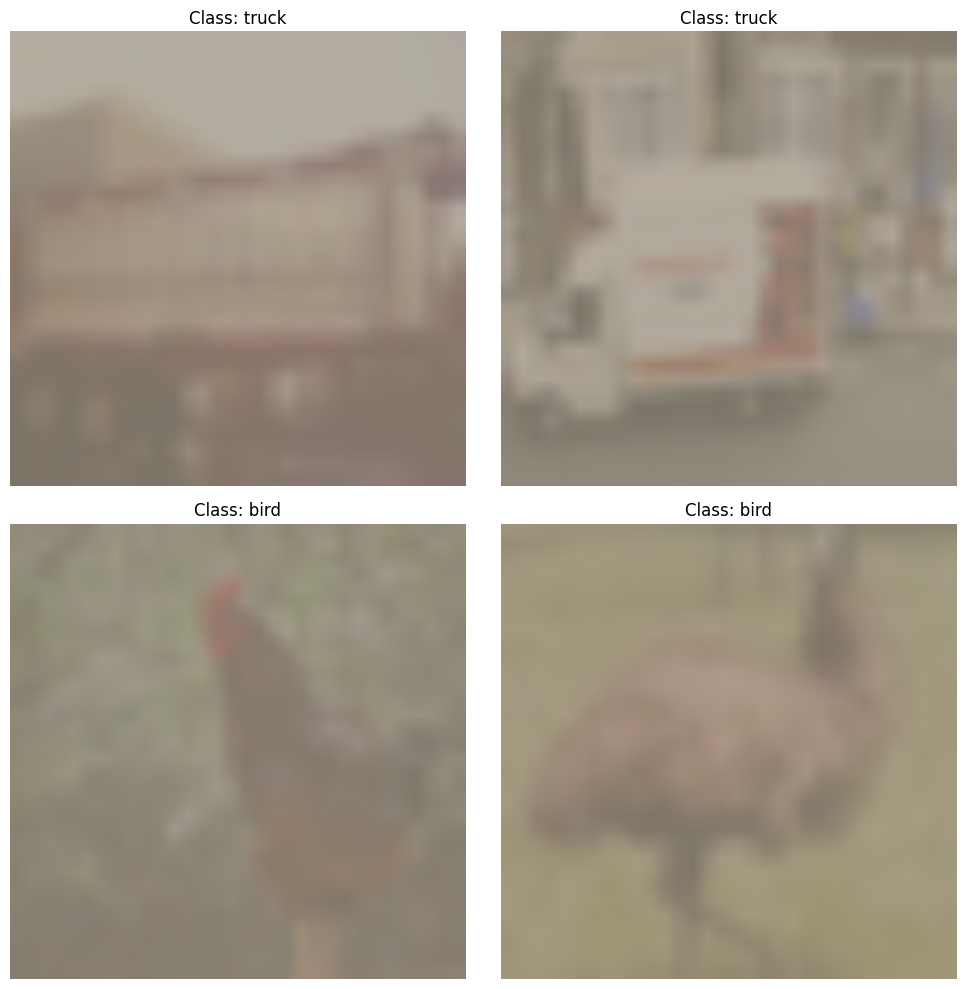

In [189]:
%load_ext autoreload
%autoreload 2

from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 expects 224x224 images
    transforms.ToTensor()
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create a figure to display images
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    # Plot the image
    axes[i].imshow(imshow(images[i]))
    axes[i].set_title(f'Class: {classes[labels[i]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import torchvision.models as models
import matplotlib.pyplot as plt

# Load non-pretrained ResNet50 and train with SimCLR
resnet50 = models.resnet50(pretrained=False)
trained_resnet50, losses = SimCLR(resnet50, train_loader, nn.Identity(), 224, 224).train()

# Create a figure for plotting the losses
plt.figure(figsize=(15, 5))

# Plot batch losses
plt.subplot(1, 2, 1)
plt.plot(losses['batch_losses'])
plt.title('Training Loss (Per Batch)')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Plot epoch losses
plt.subplot(1, 2, 2)
plt.plot(losses['epoch_losses'], 'ro-')
plt.title('Training Loss (Per Epoch)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)

# Add a smoothed version of batch losses (optional)
if len(losses['batch_losses']) > 100:
    from scipy.ndimage import gaussian_filter1d
    
    # Apply smoothing
    smoothed_losses = gaussian_filter1d(losses['batch_losses'], sigma=50)
    
    # Add to the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(smoothed_losses, 'r-', alpha=0.7, linewidth=2, label='Smoothed')
    plt.legend()

plt.tight_layout()
plt.show()

# Save the plots if needed
plt.savefig('simclr_training_losses.png', dpi=300, bbox_inches='tight')

print(f"Final training loss: {losses['epoch_losses'][-1]:.4f}")

Starting training


Epoch 1/10:   1%|█▏                                                                                                                                                | 100/12500 [00:54<1:49:58,  1.88it/s, loss=0.8430]

Iteration 100, Loss: 0.8430


Epoch 1/10:   2%|██▎                                                                                                                                               | 200/12500 [01:48<1:49:38,  1.87it/s, loss=0.7468]

Iteration 200, Loss: 0.7468


Epoch 1/10:   2%|███▌                                                                                                                                              | 300/12500 [02:42<1:47:43,  1.89it/s, loss=0.7625]

Iteration 300, Loss: 0.7625


Epoch 1/10:   3%|████▏                                                                                                                                             | 357/12500 [03:13<1:52:17,  1.80it/s, loss=0.8711]